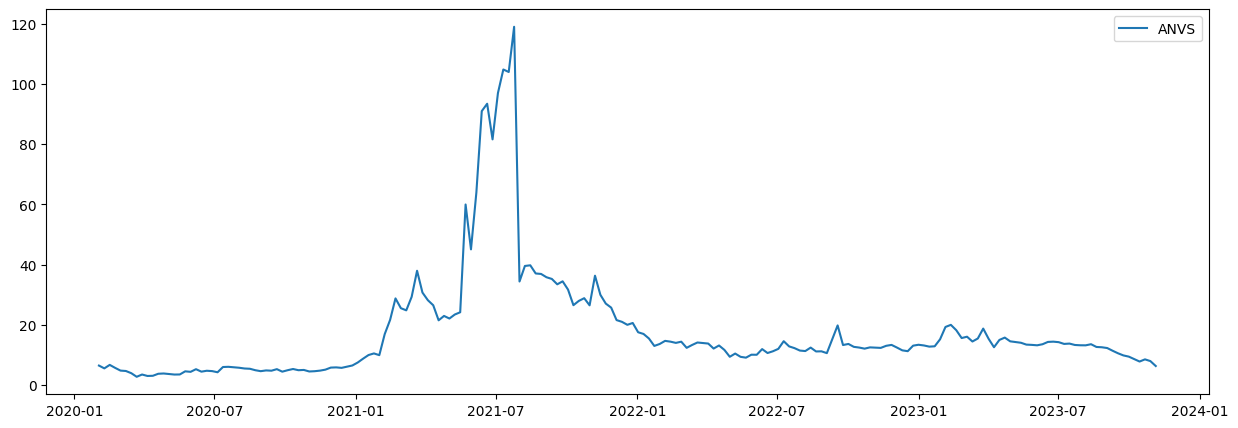

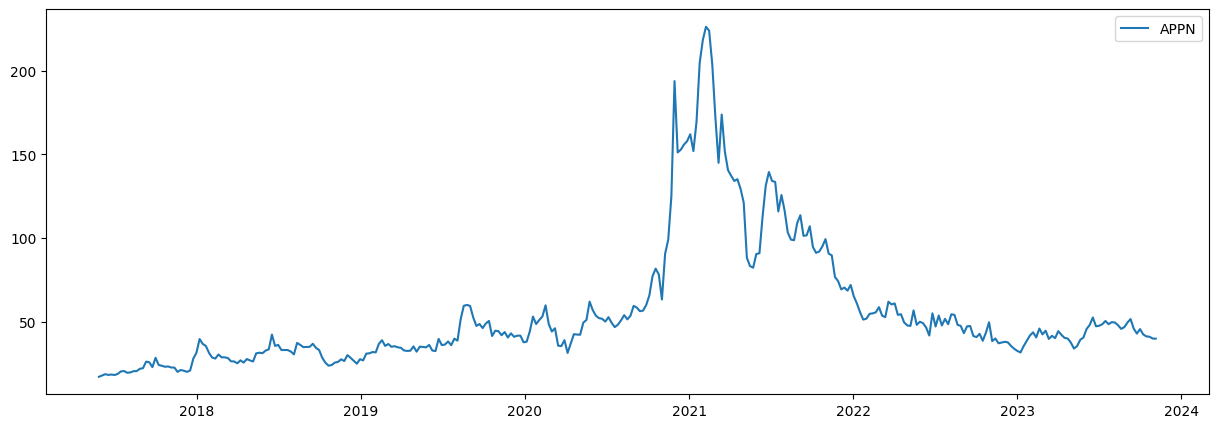

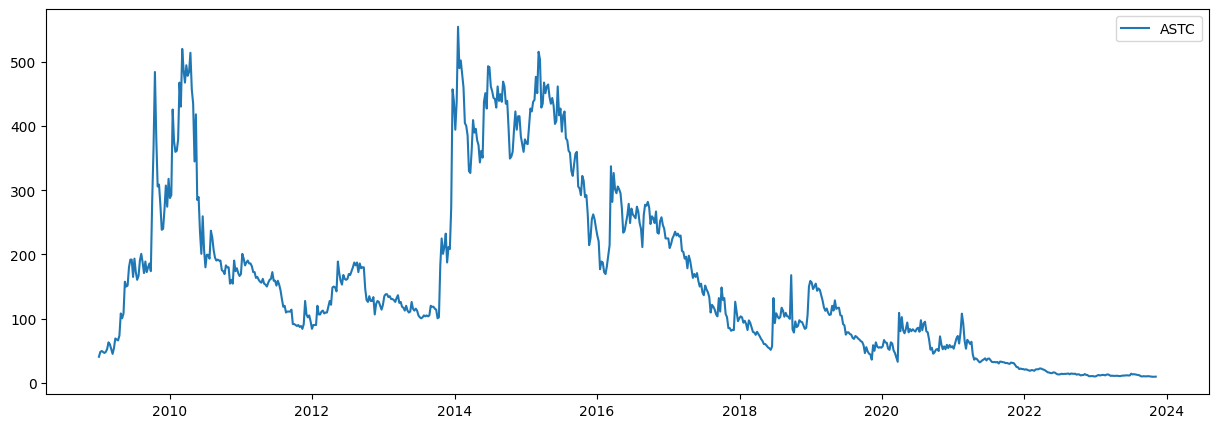

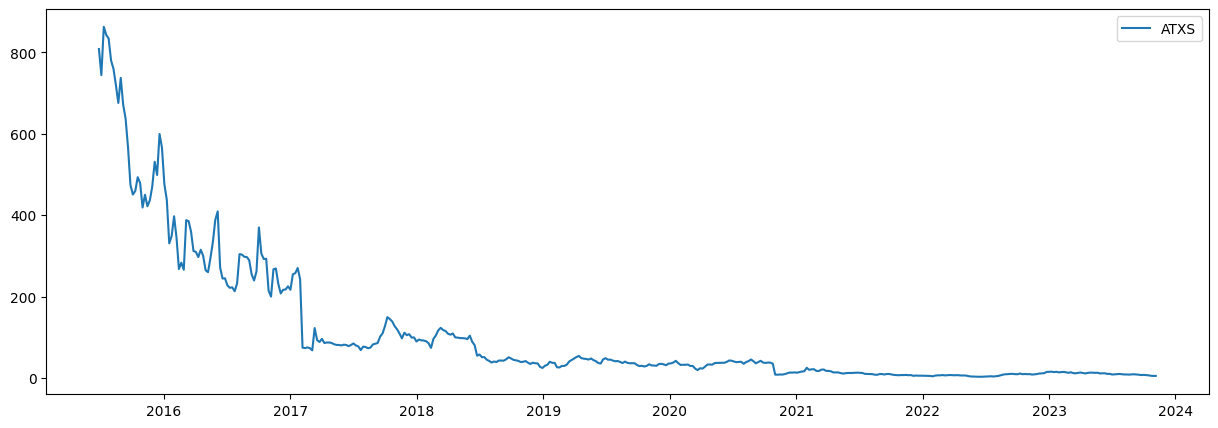

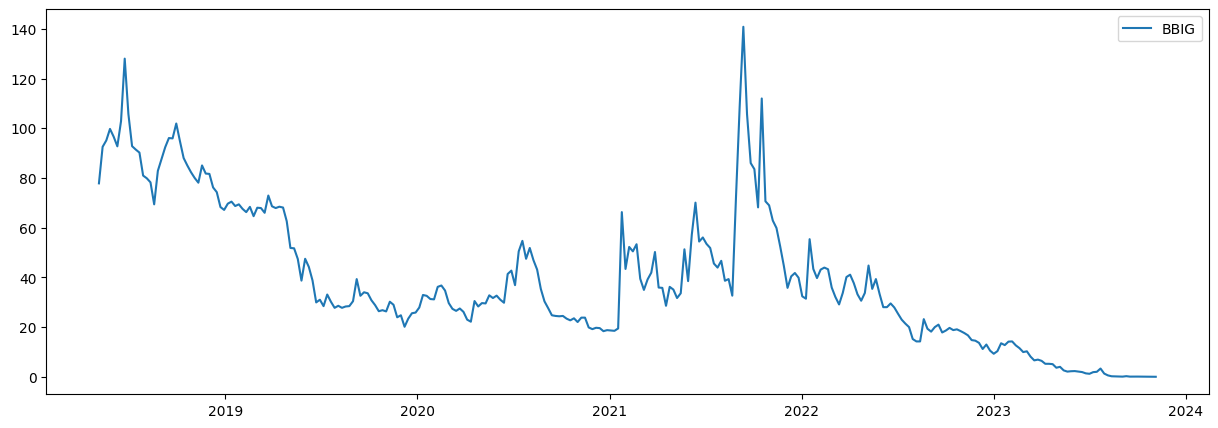

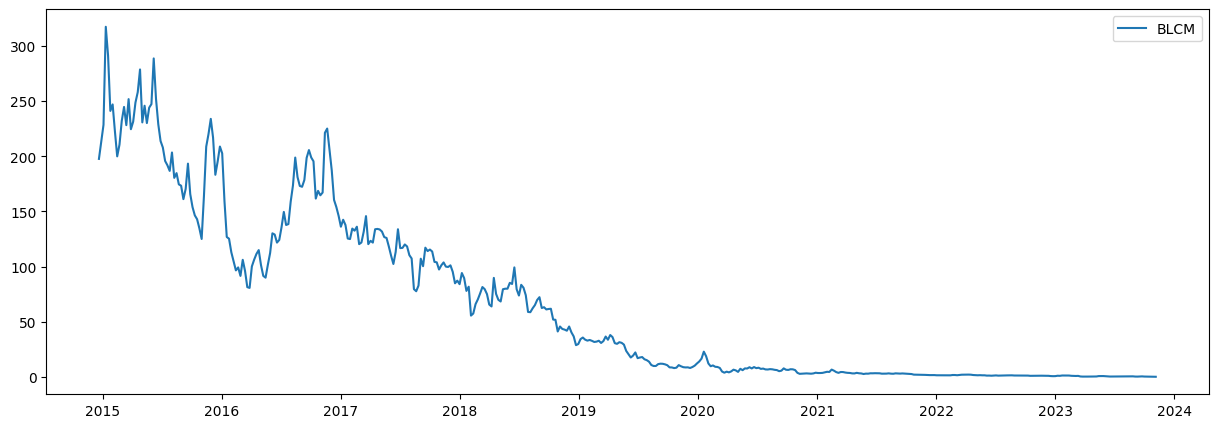

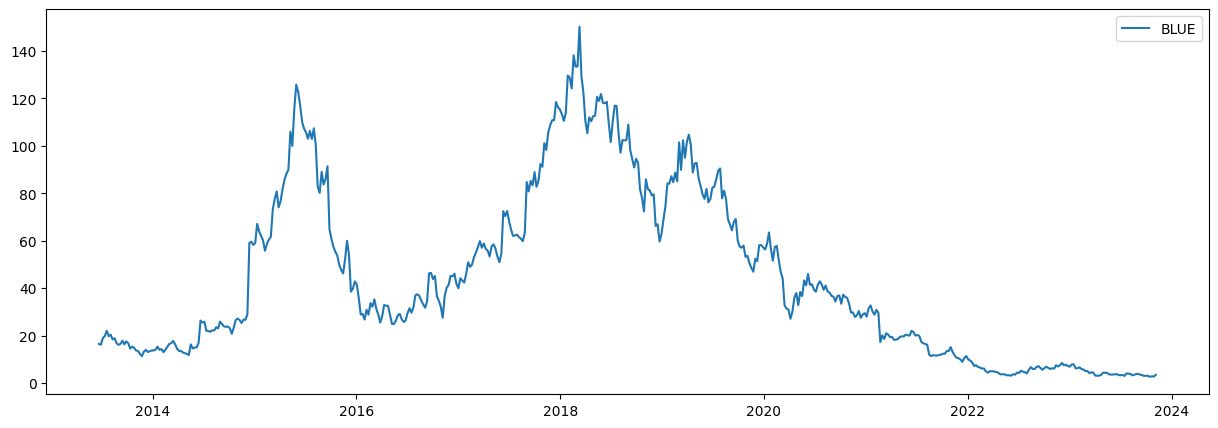


1 Failed download:
['CFMS']: Exception('%ticker%: No data found, symbol may be delisted')


No data available for the specified date range.


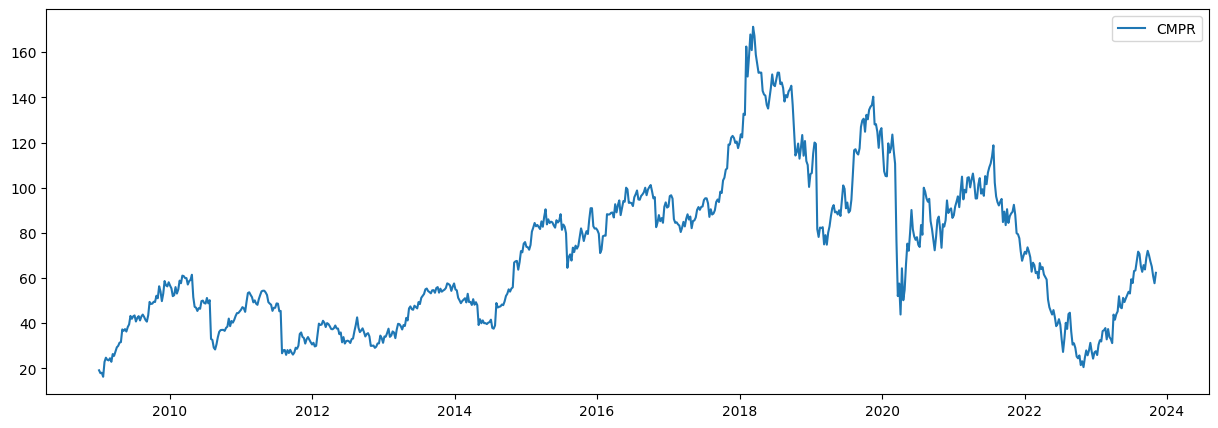

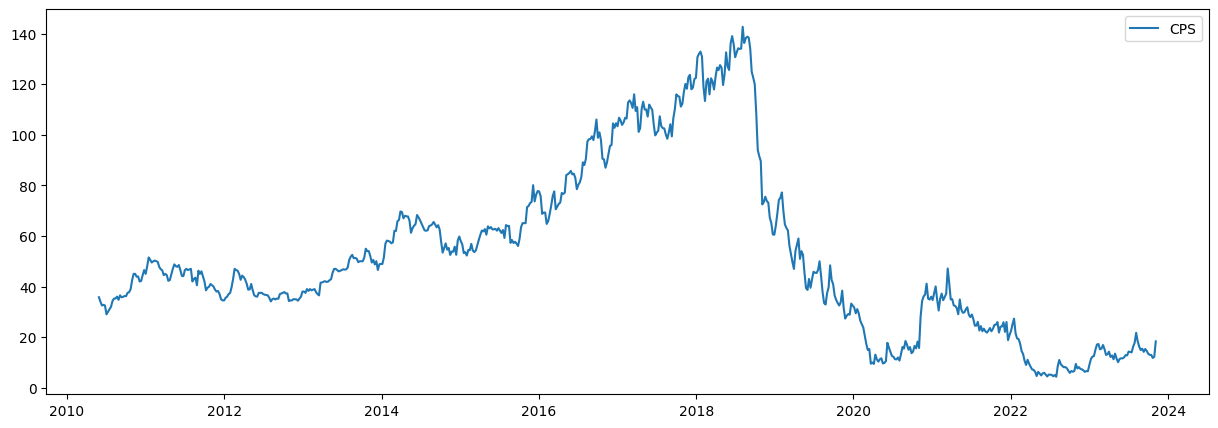

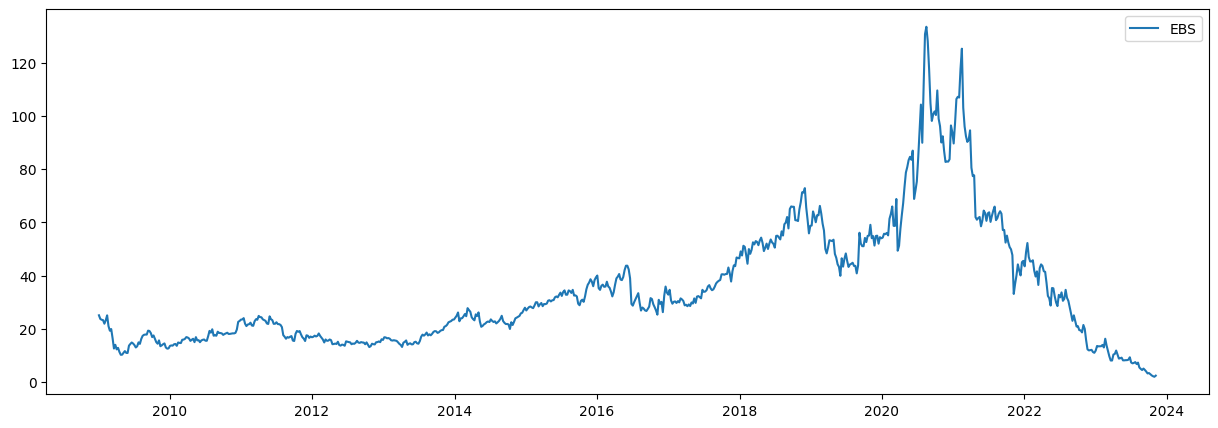

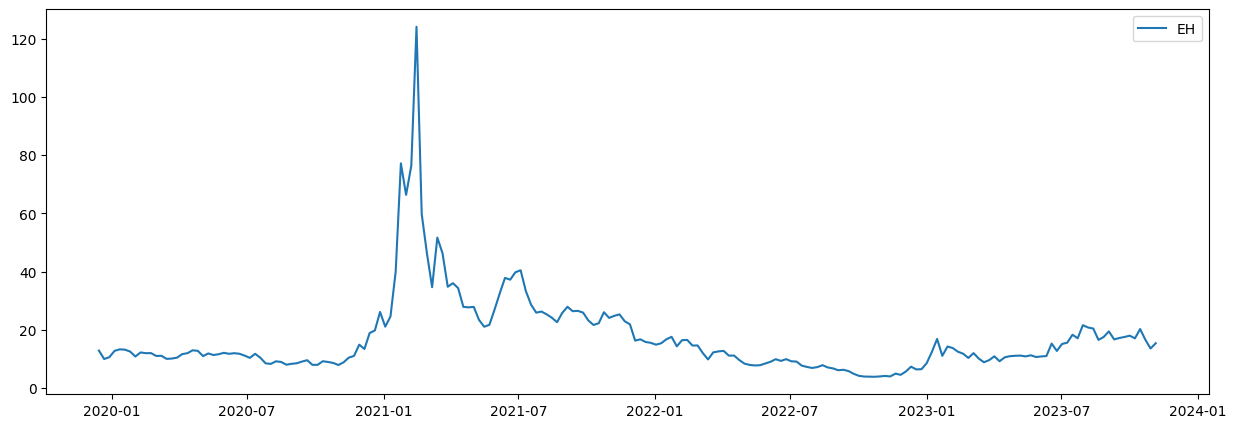

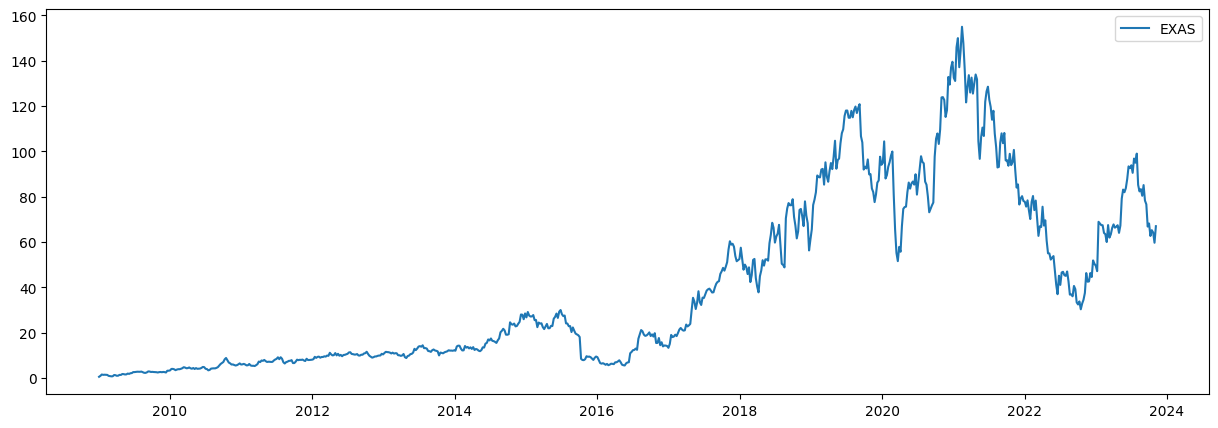

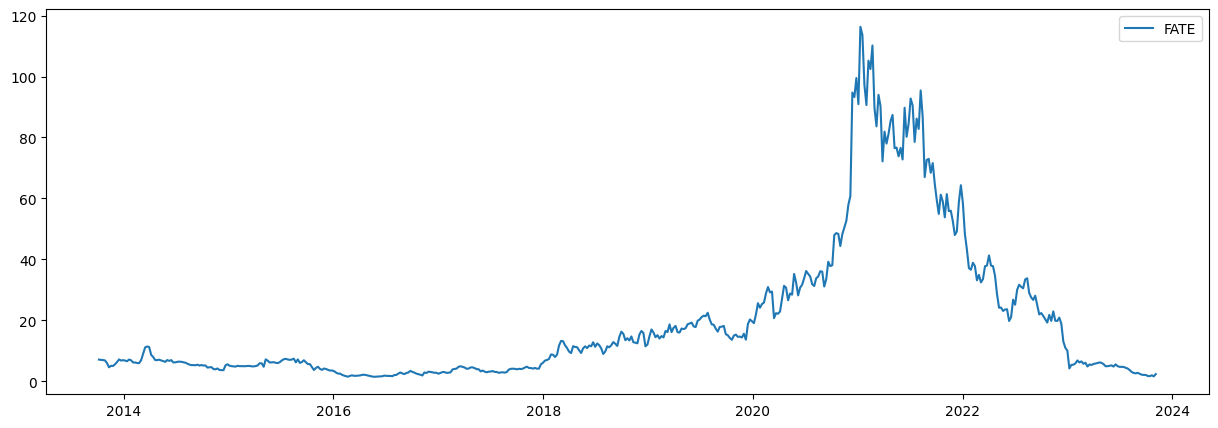

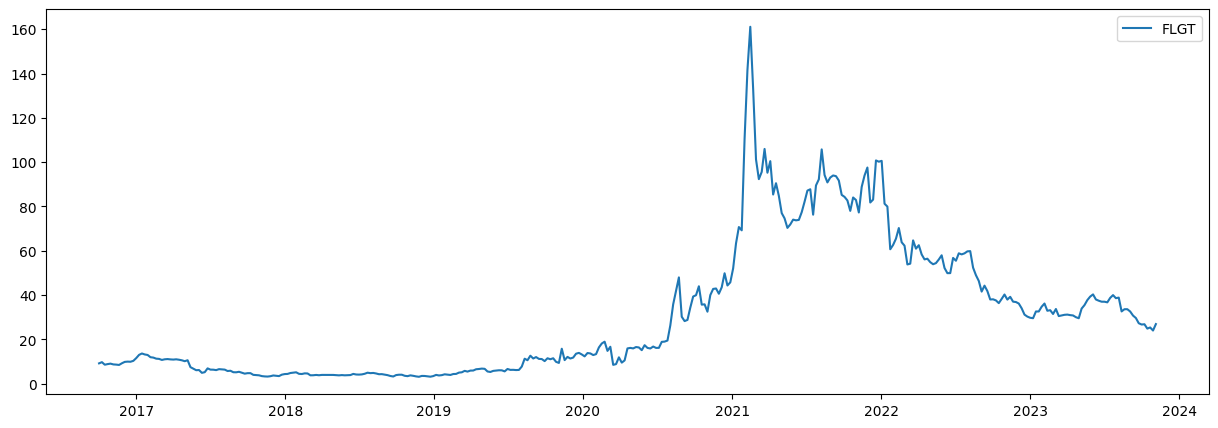

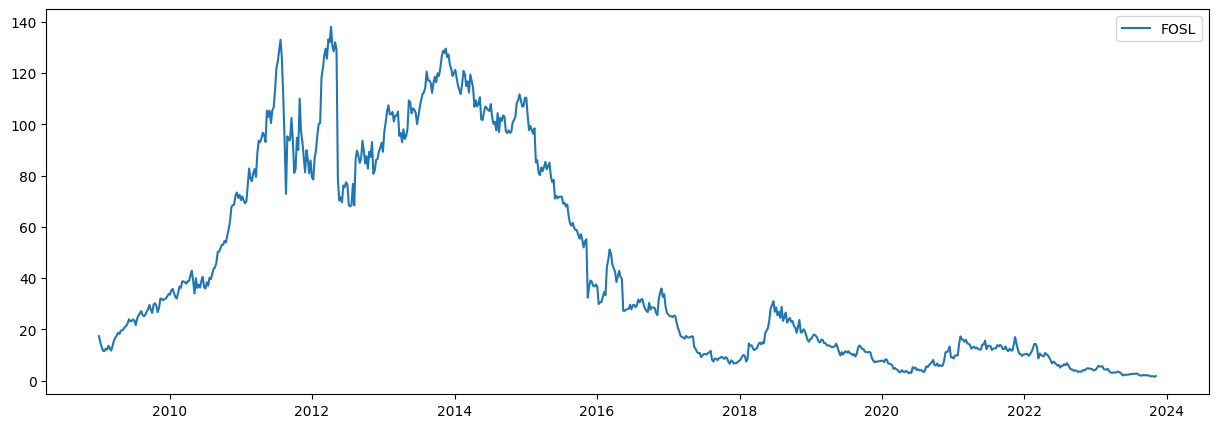

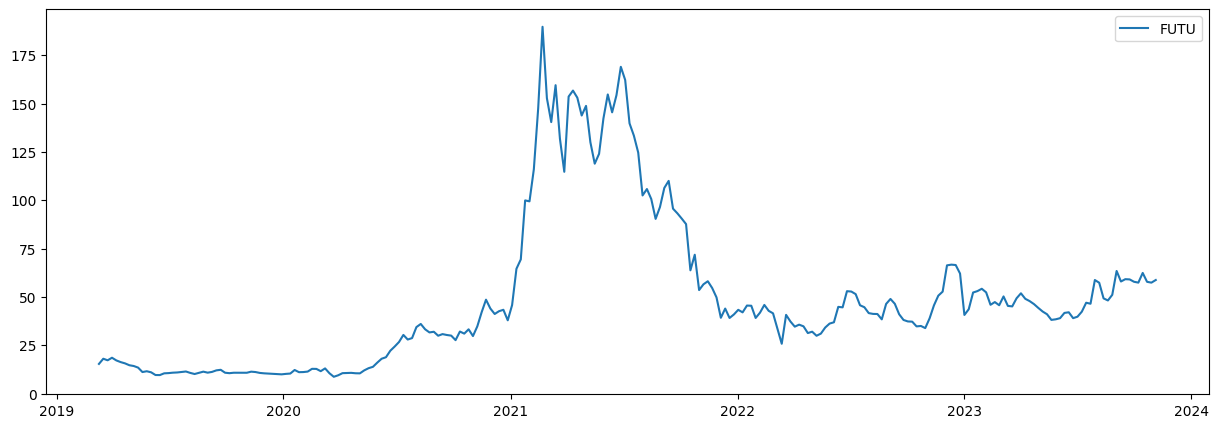

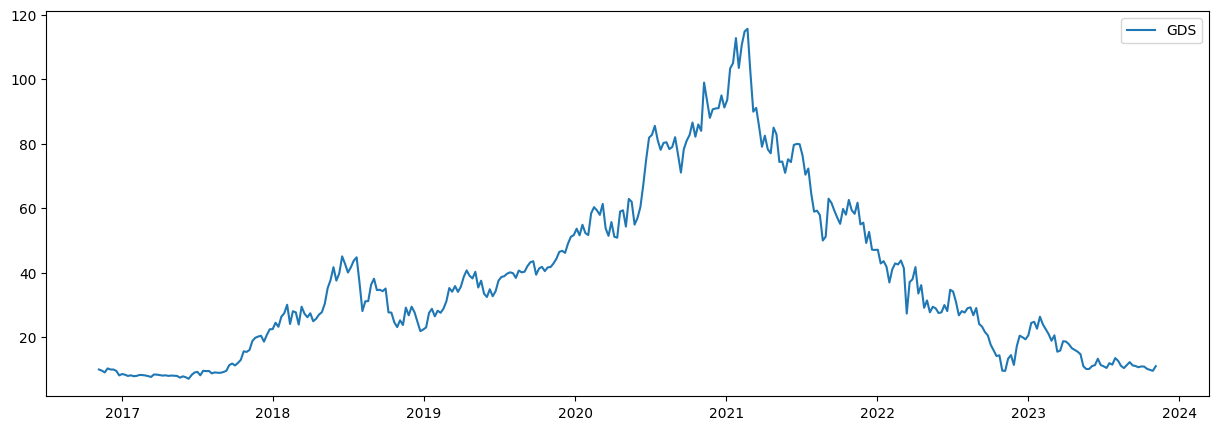

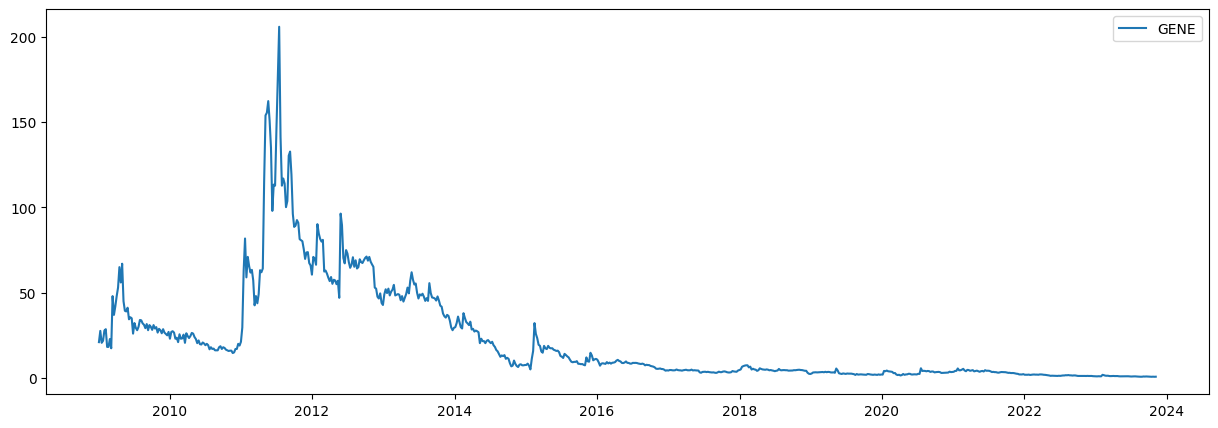

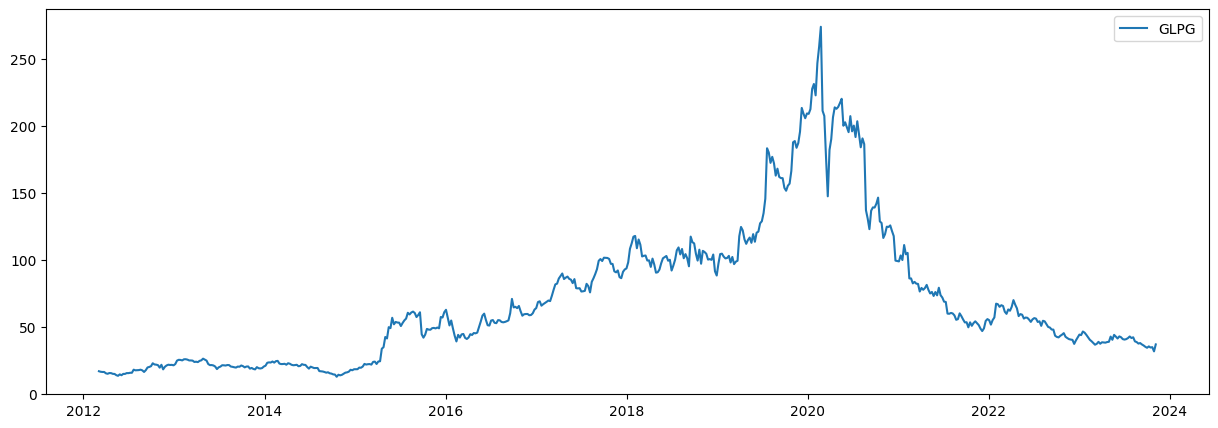

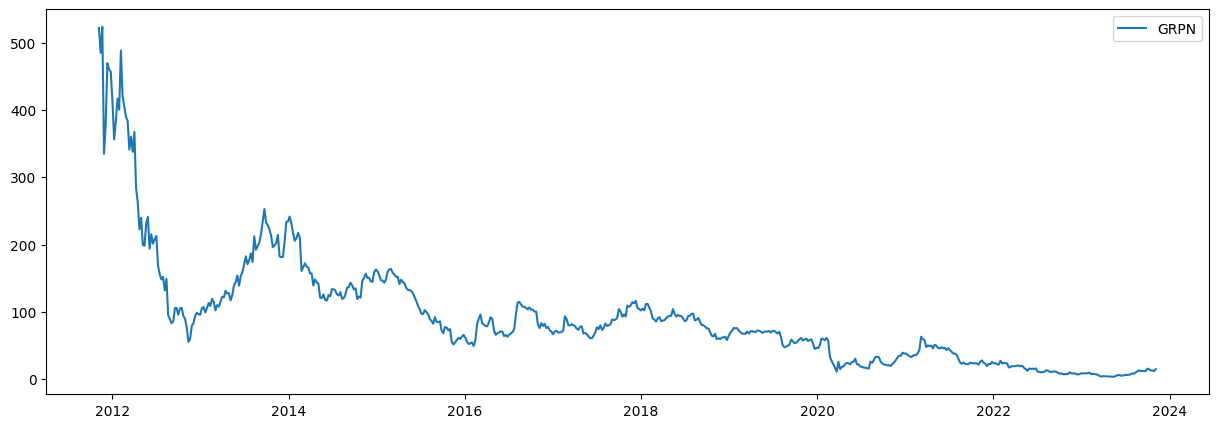

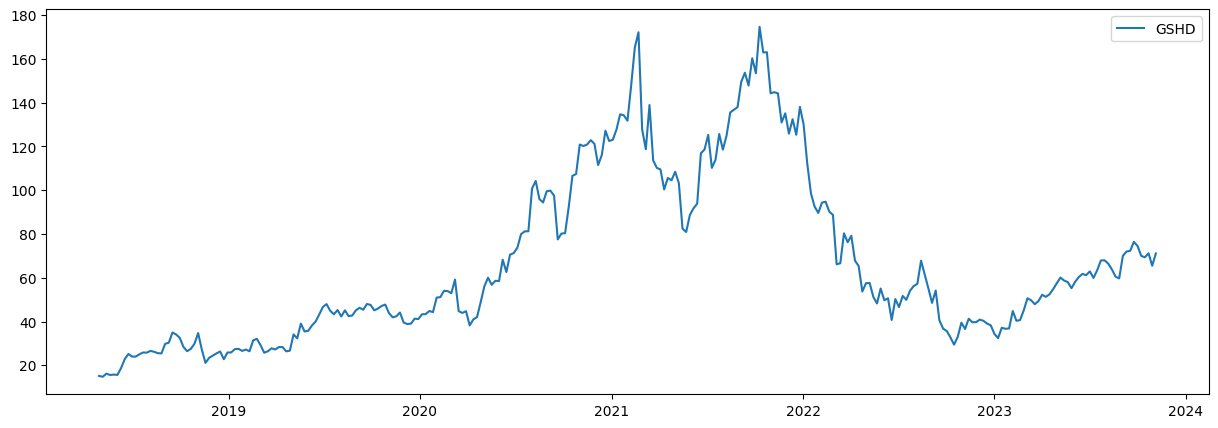

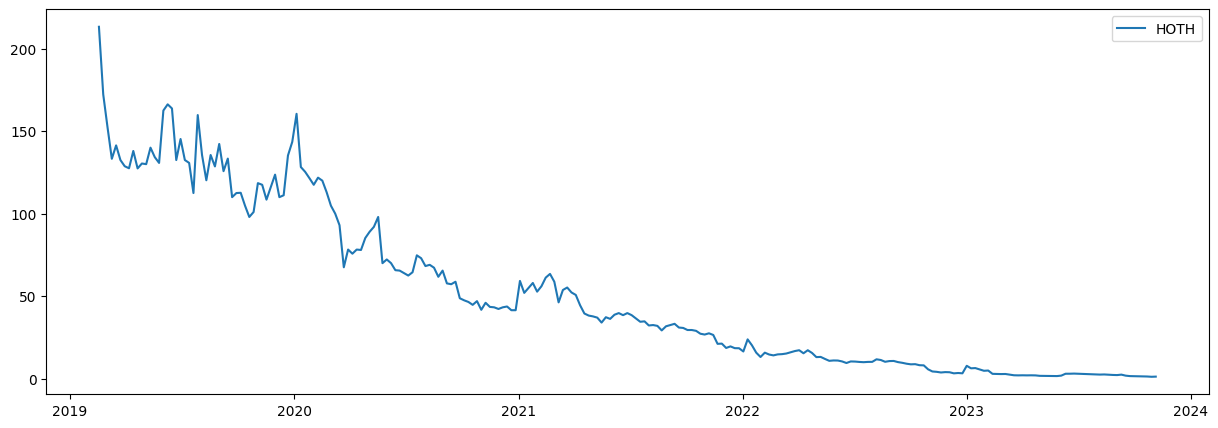

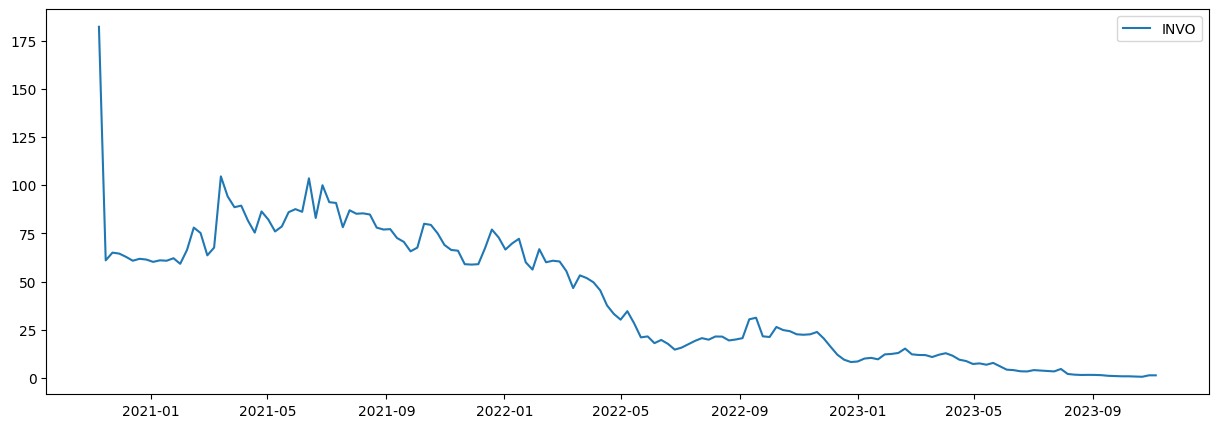

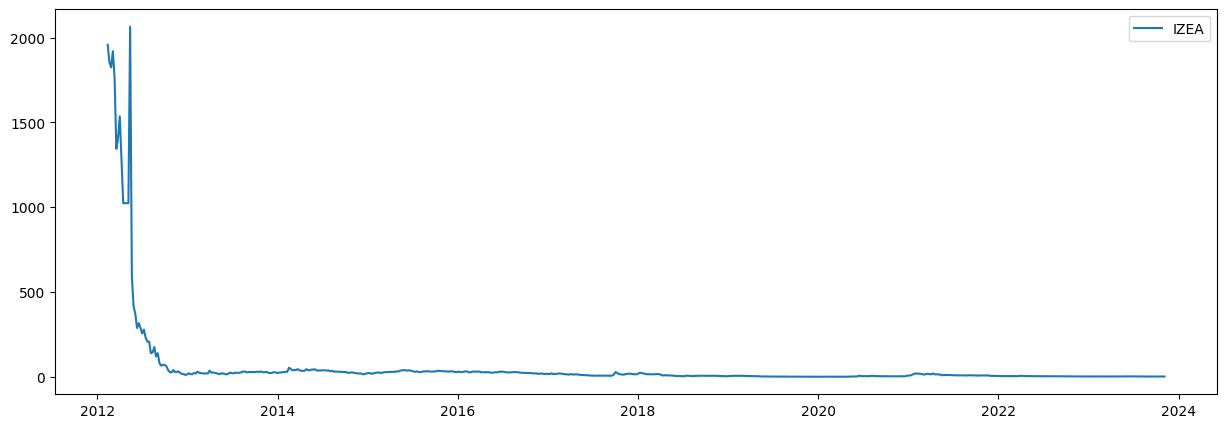

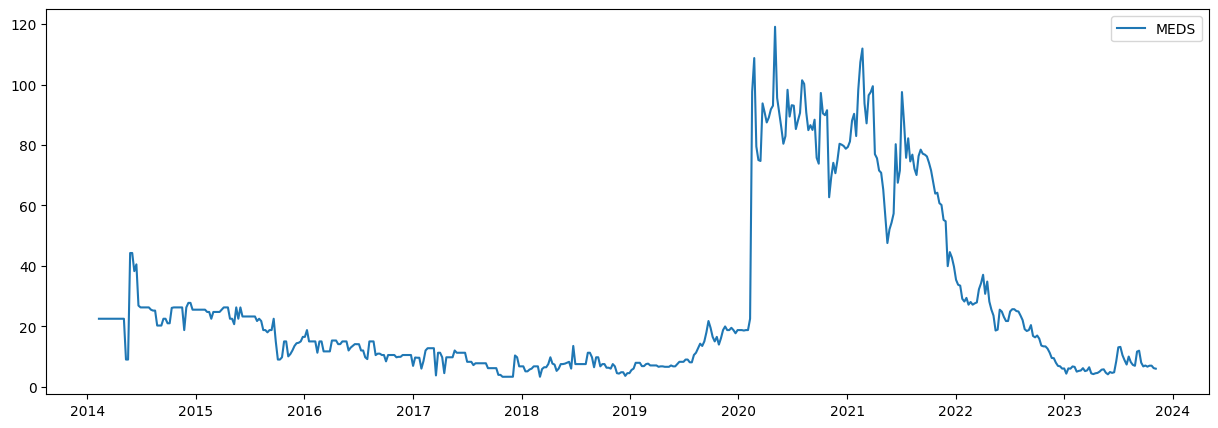

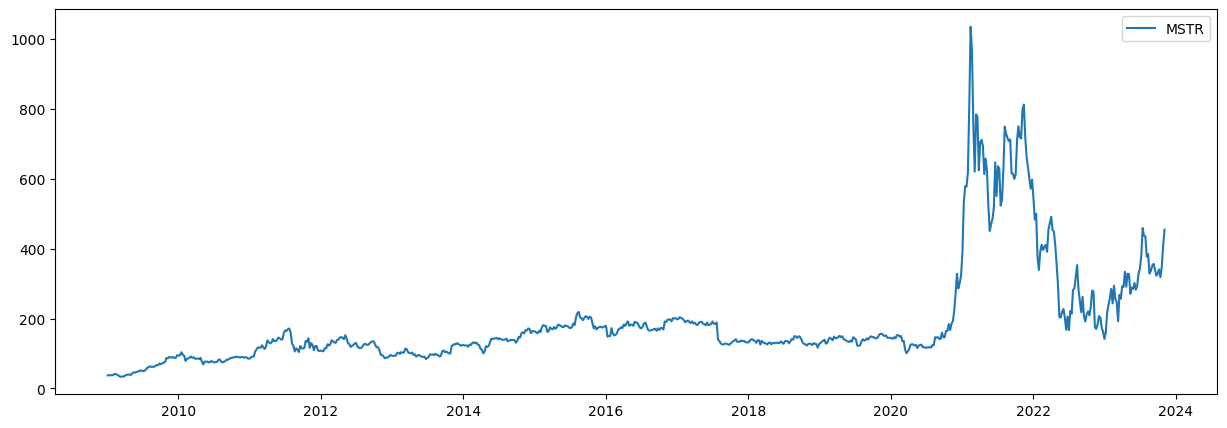

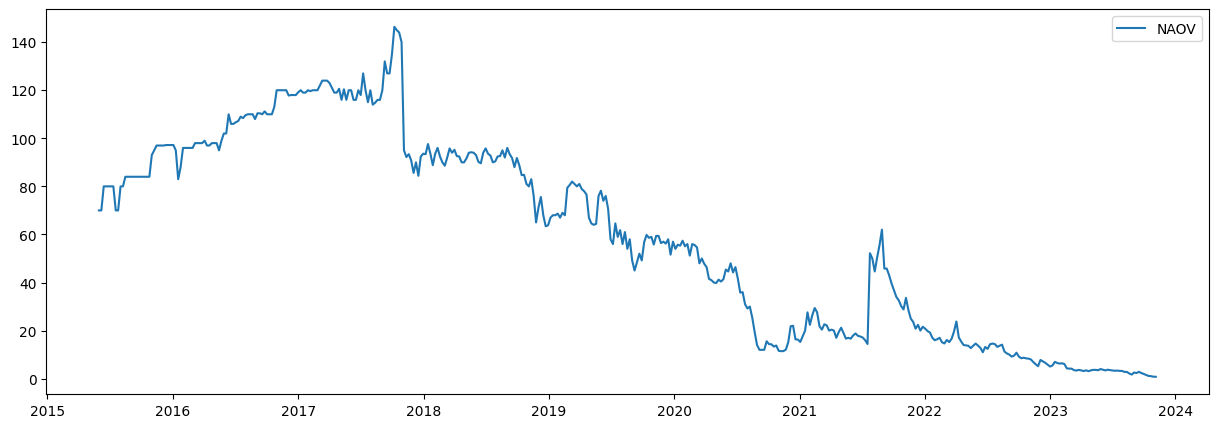

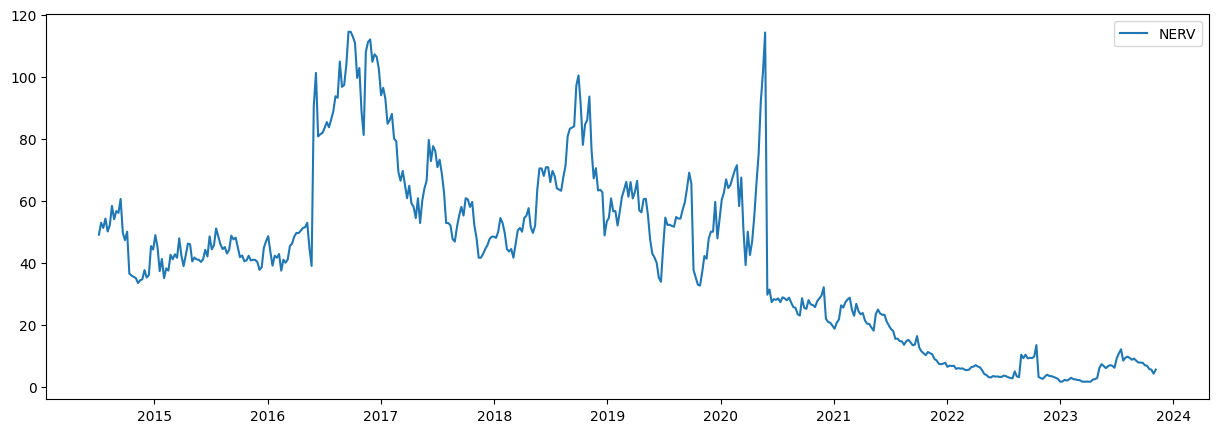

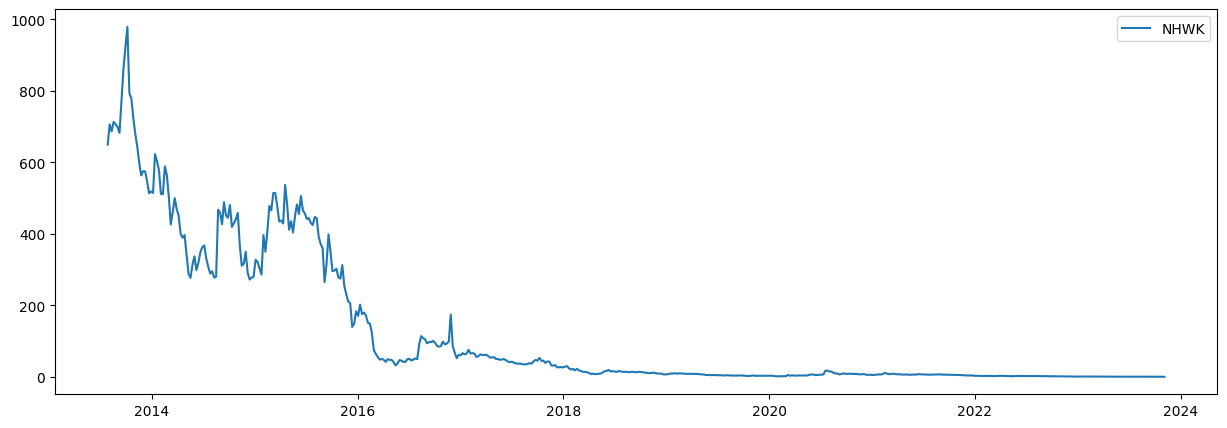

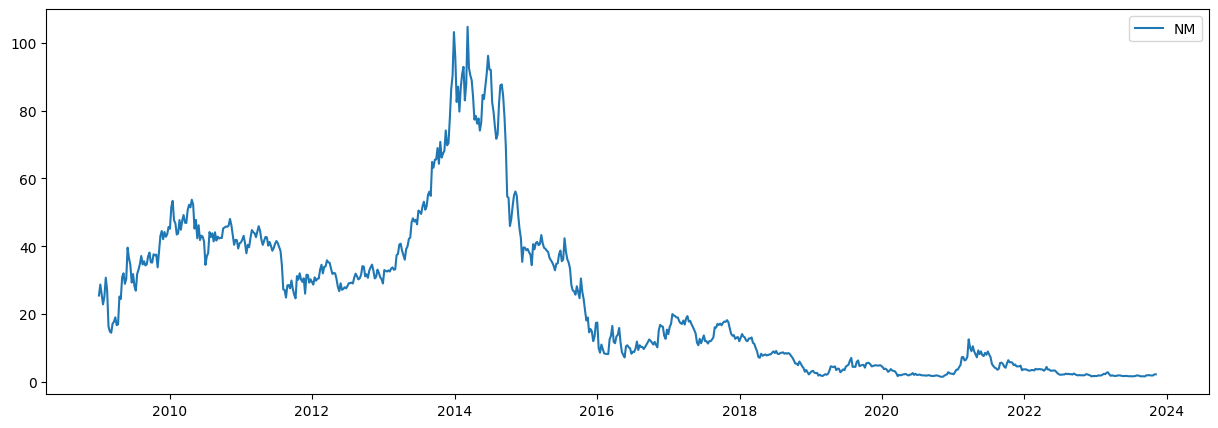

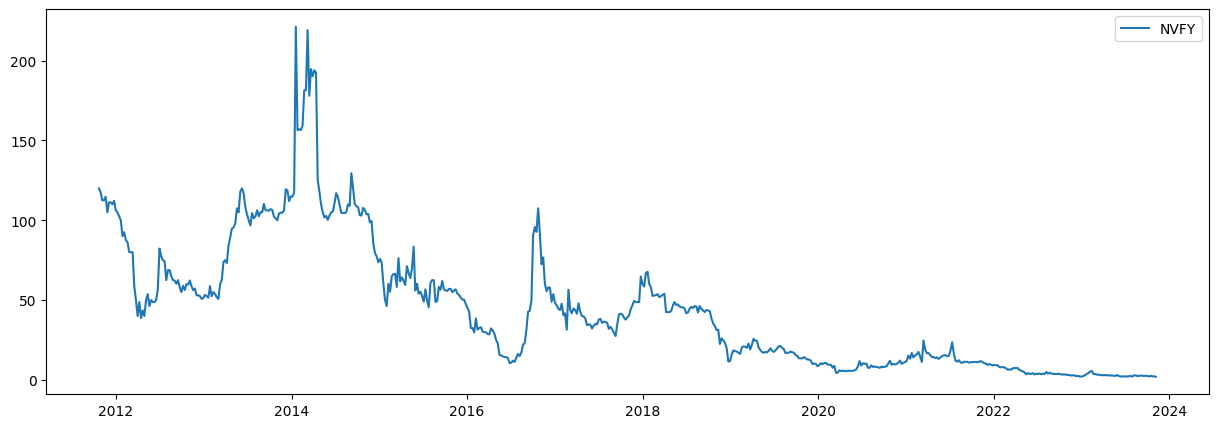

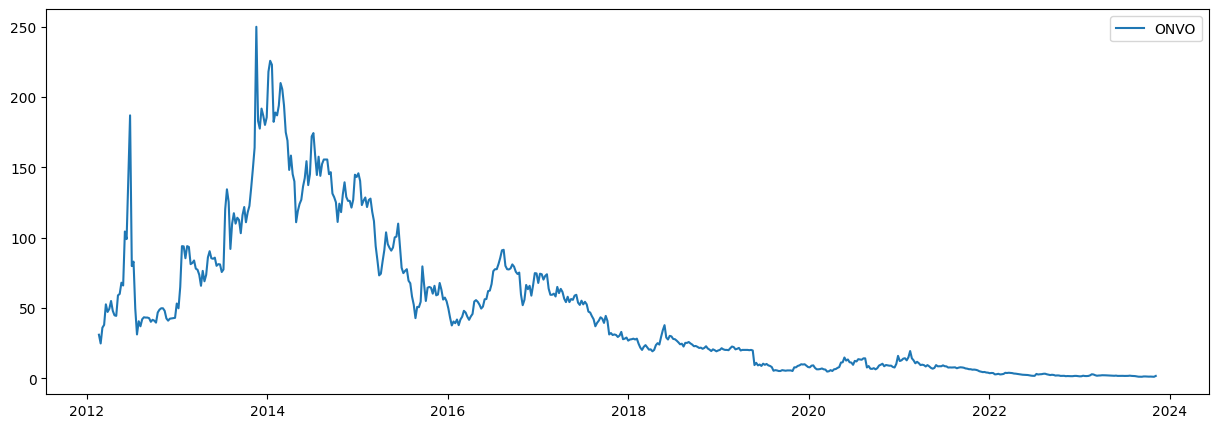

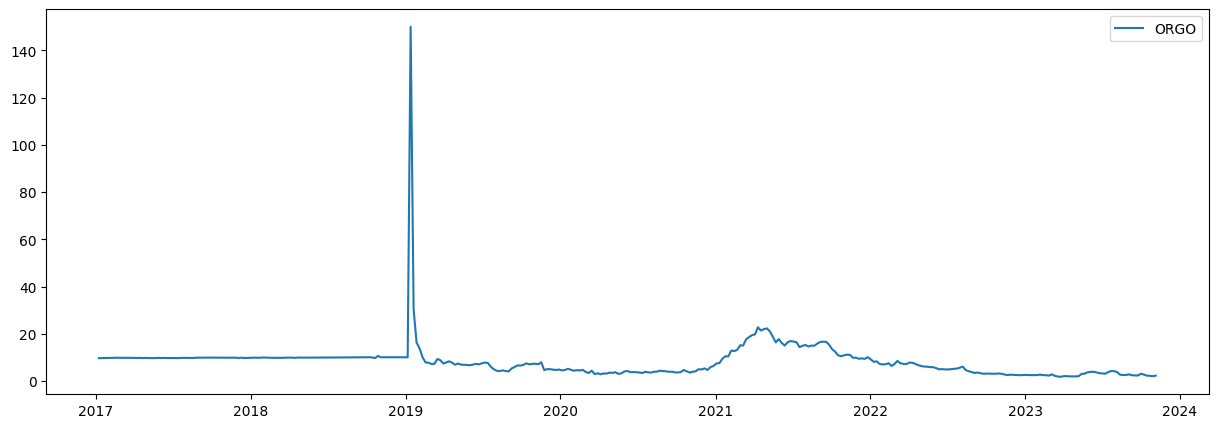

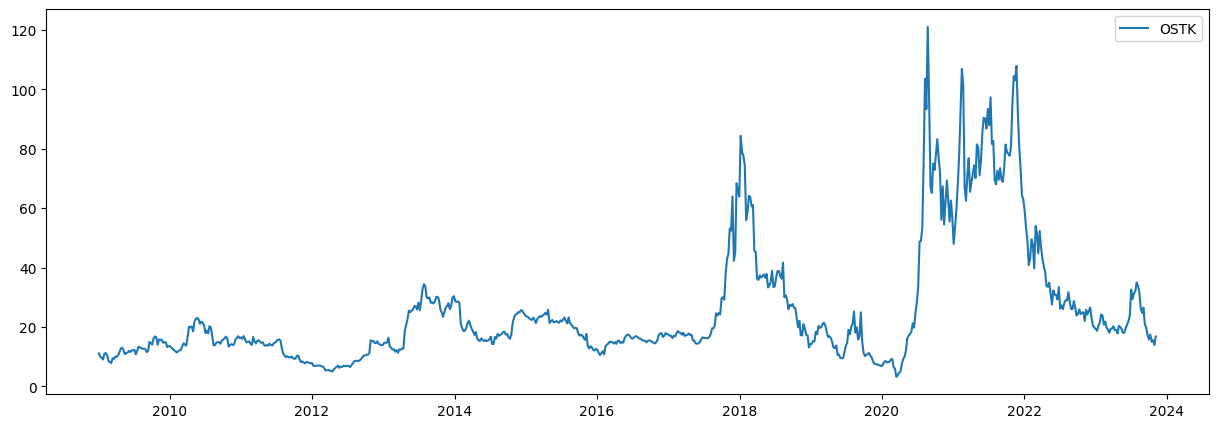

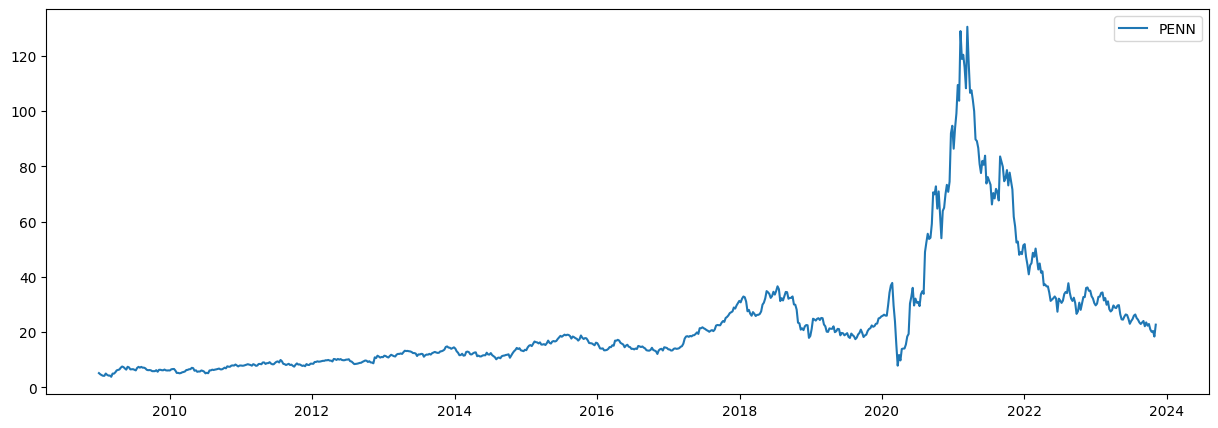

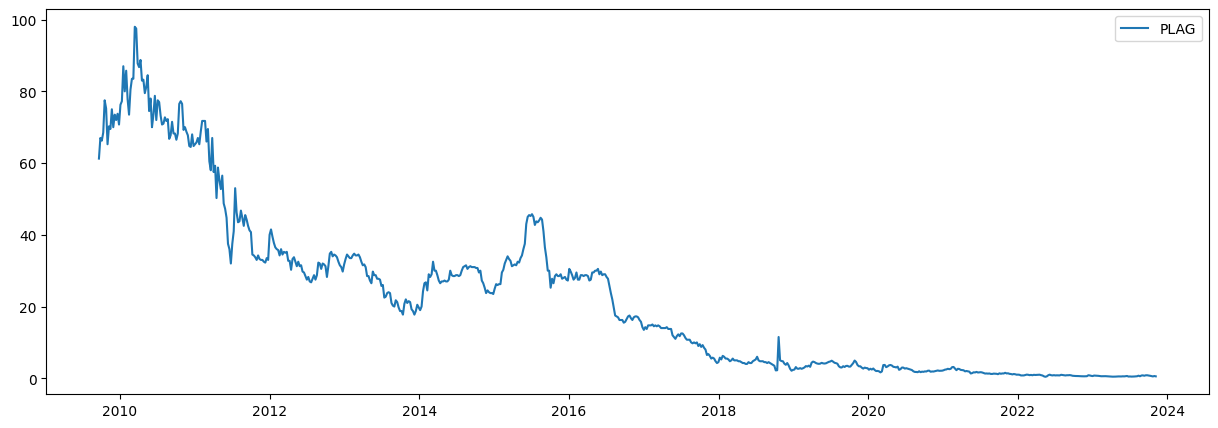

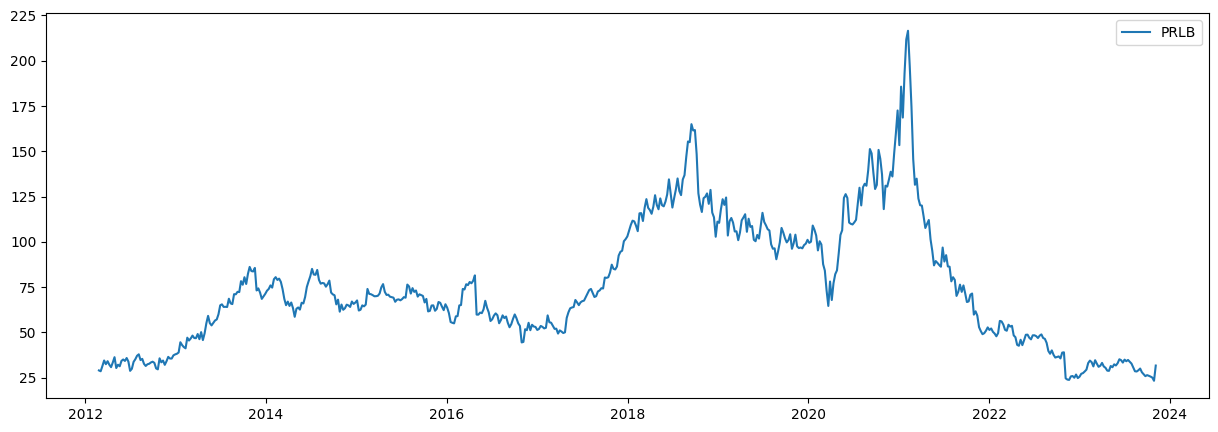

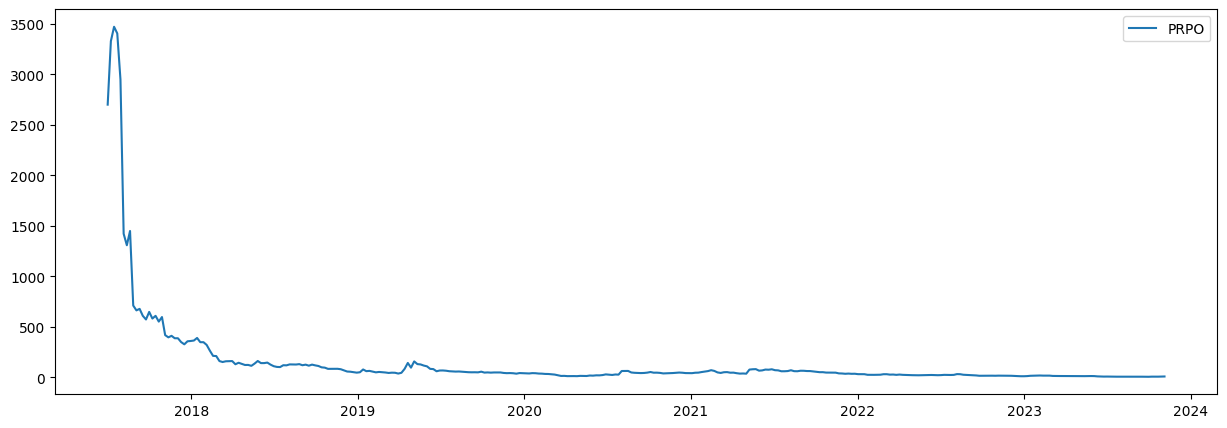

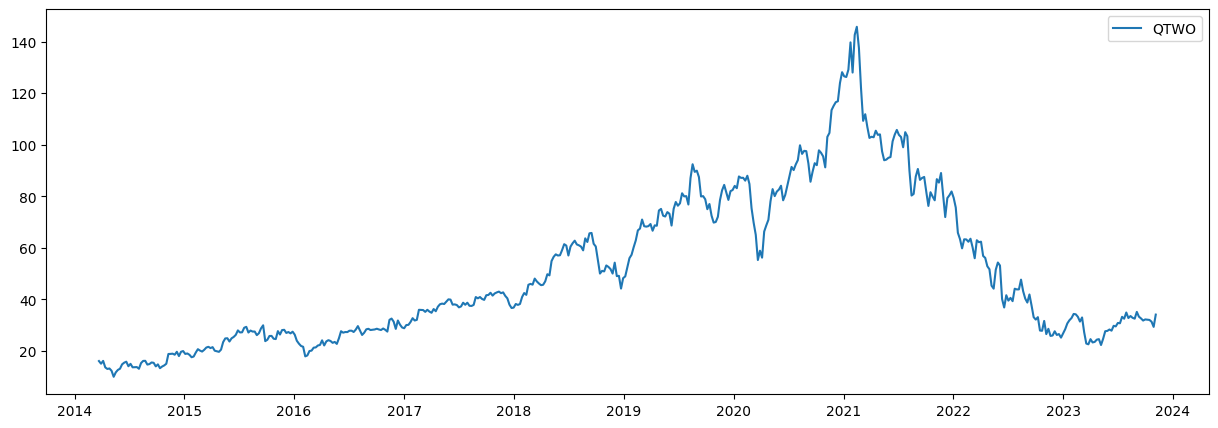

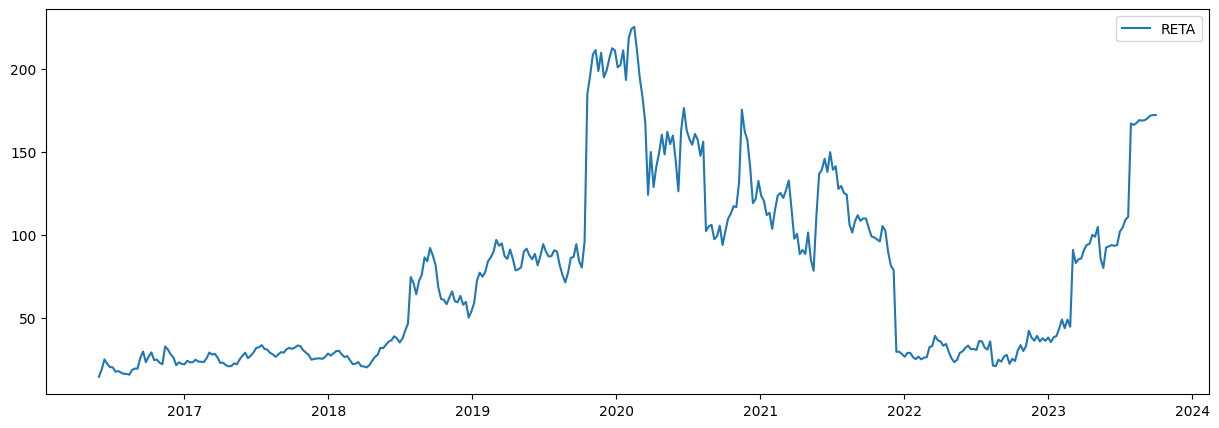

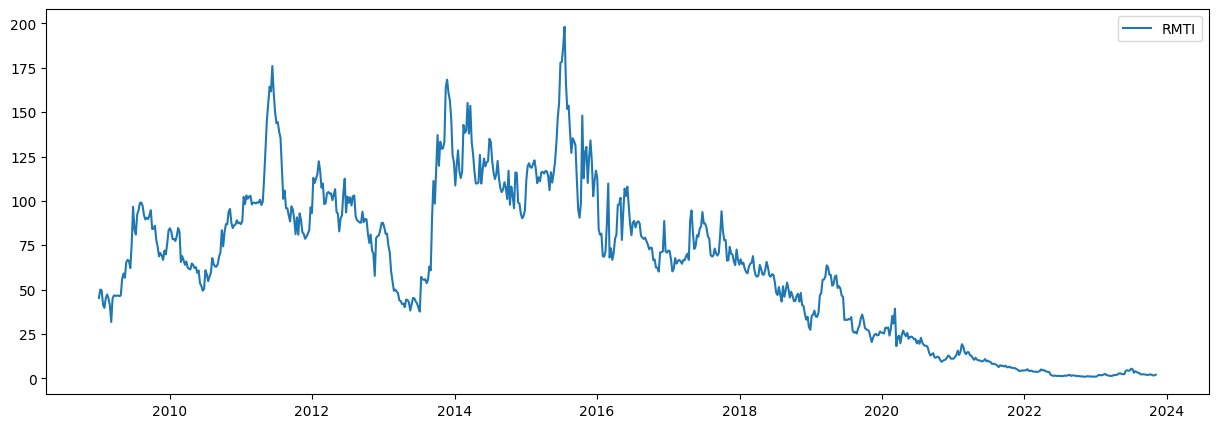

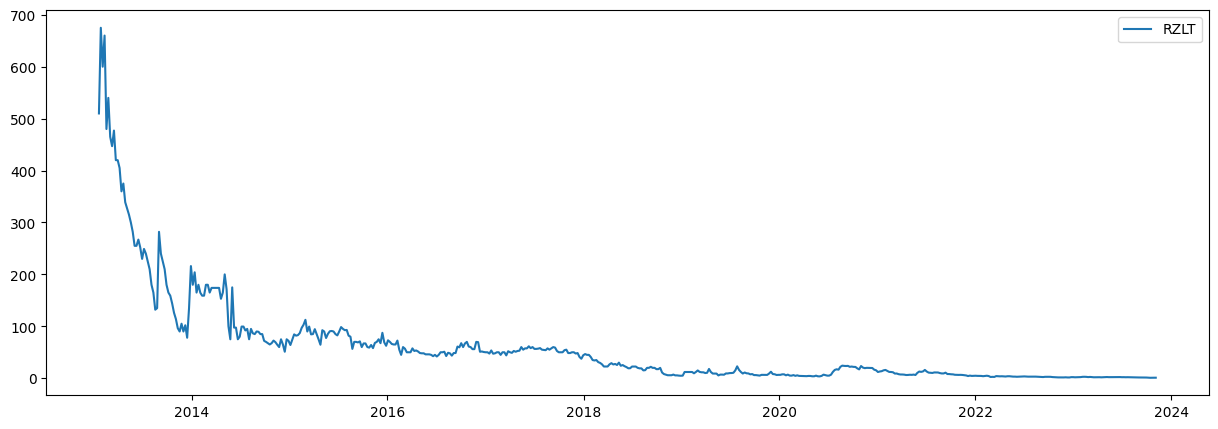

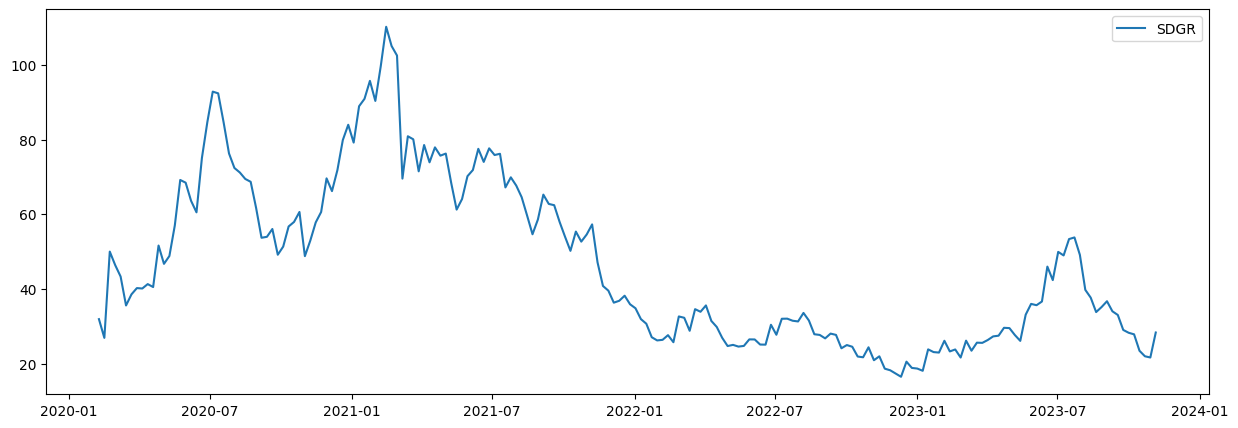

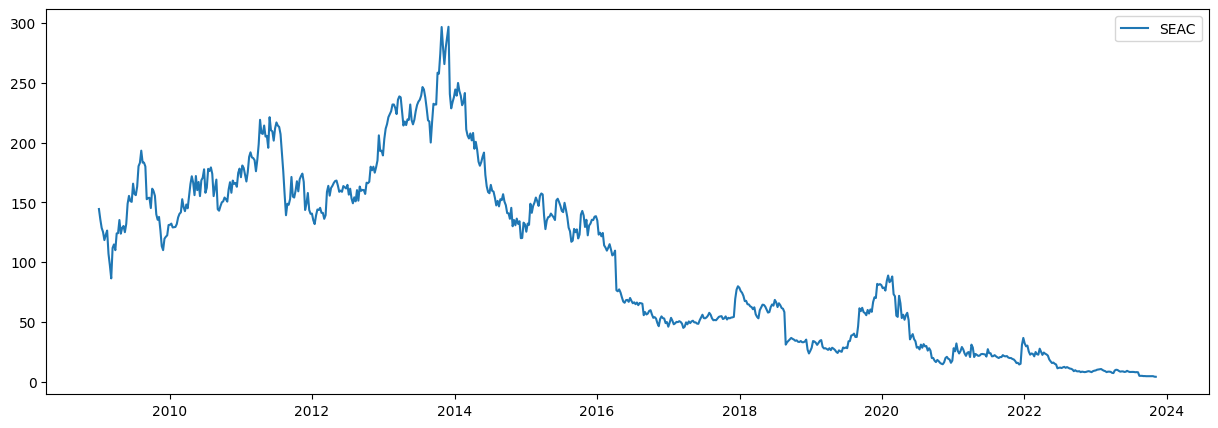

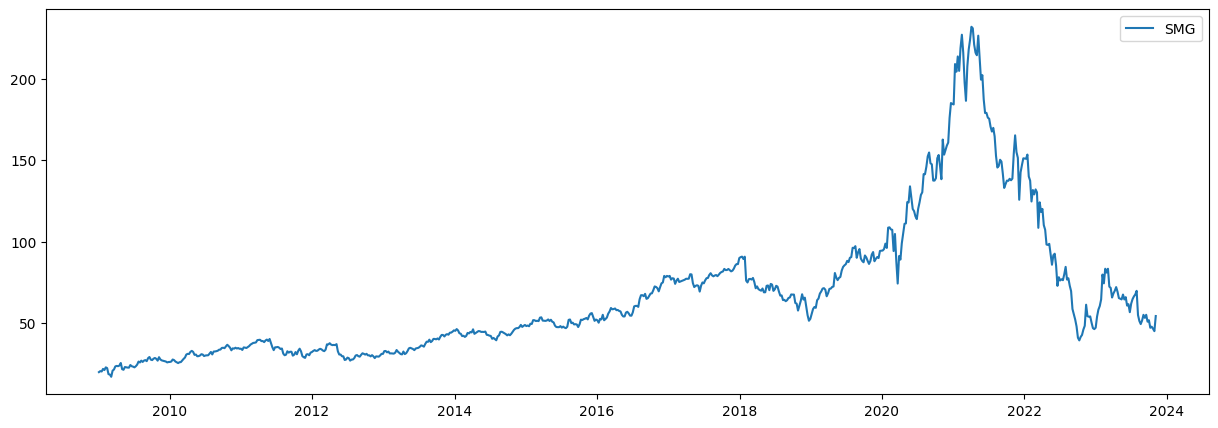

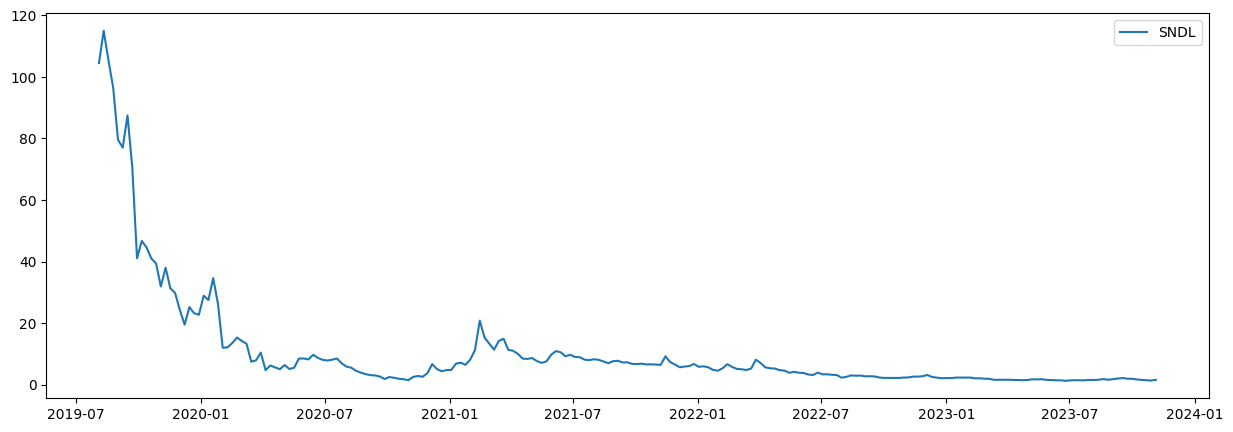

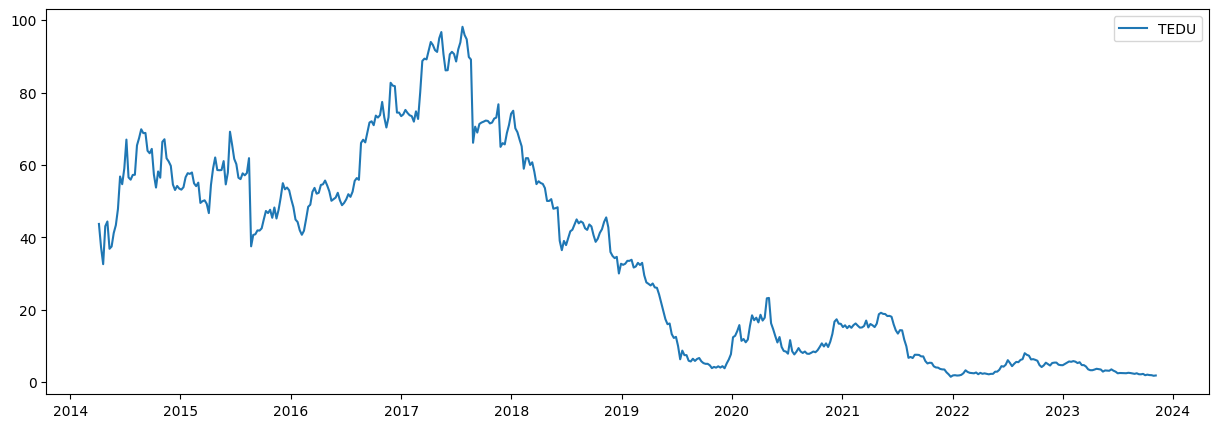

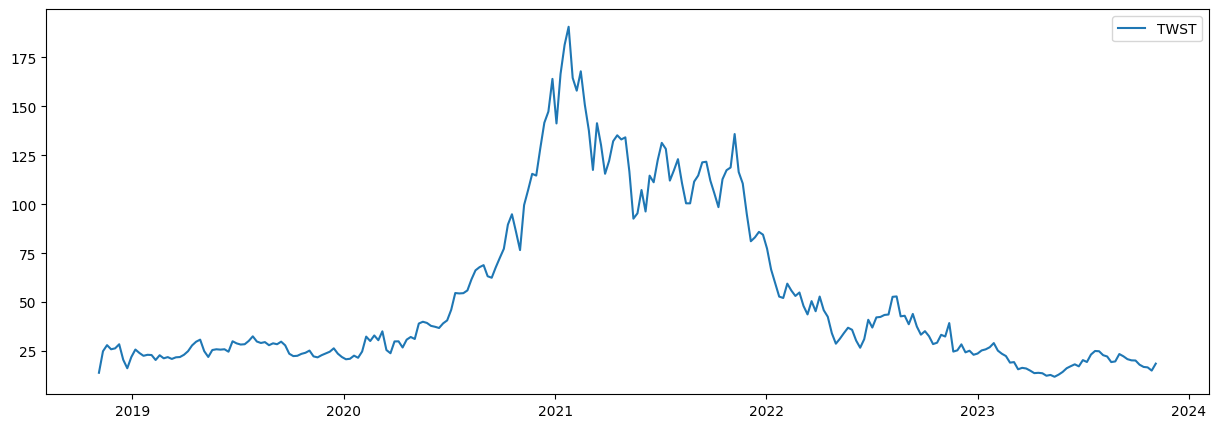

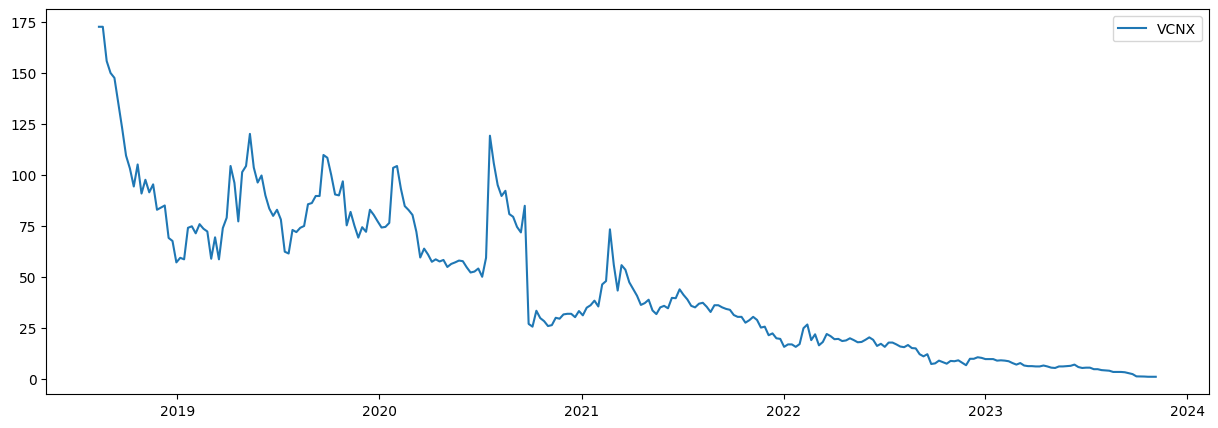

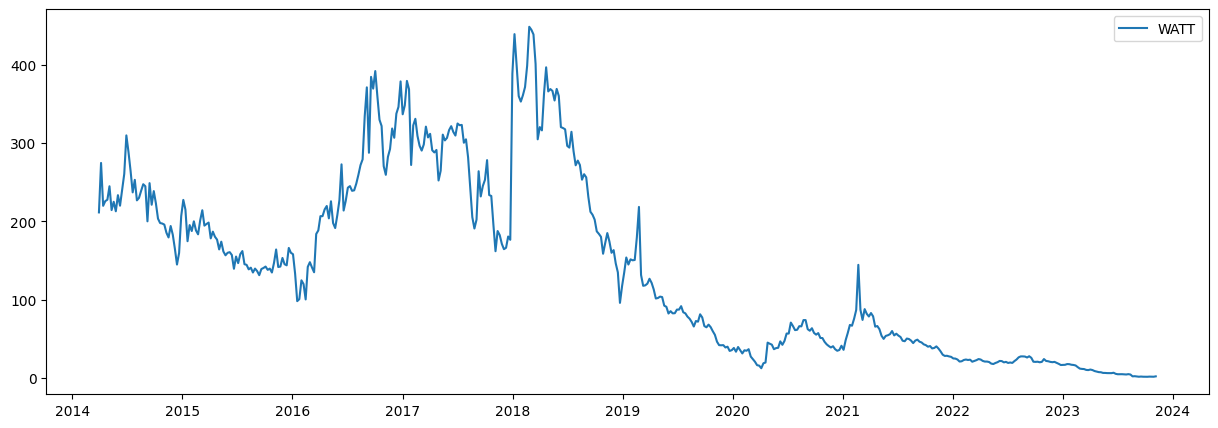

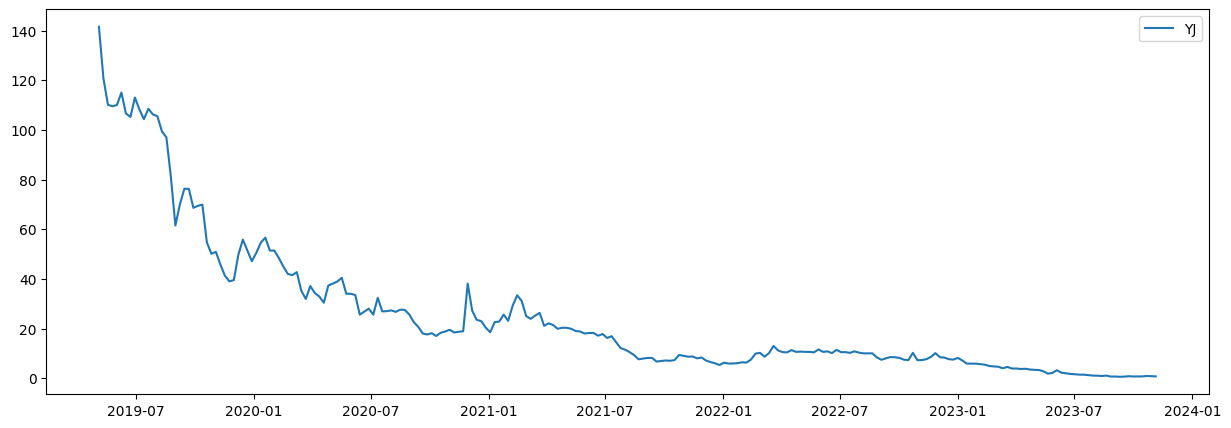


1 Failed download:
['YVR']: Exception('%ticker%: No timezone found, symbol may be delisted')


No data available for the specified date range.


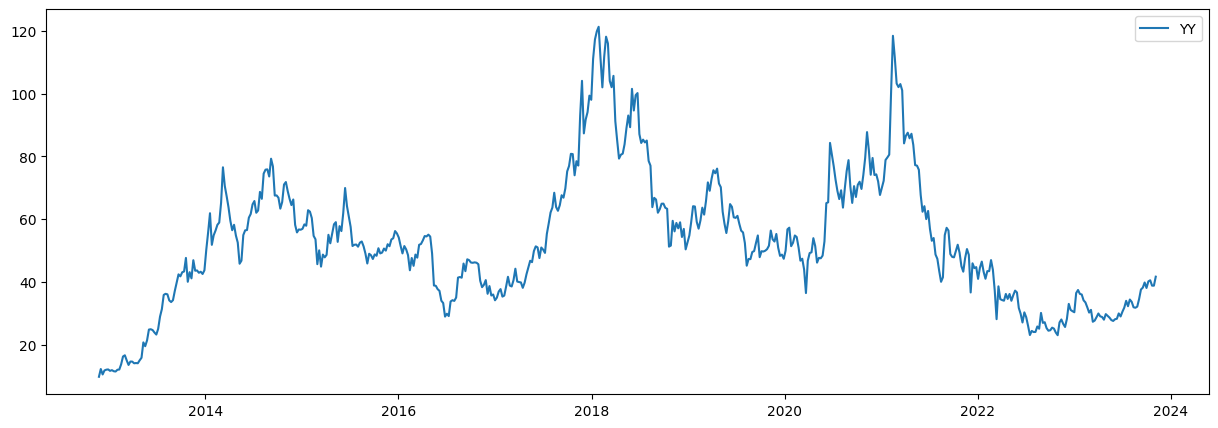

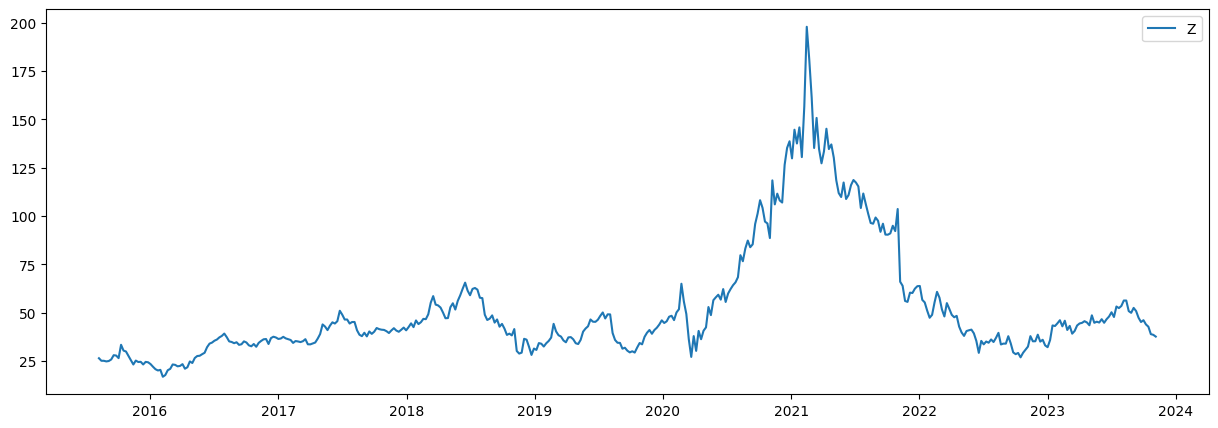

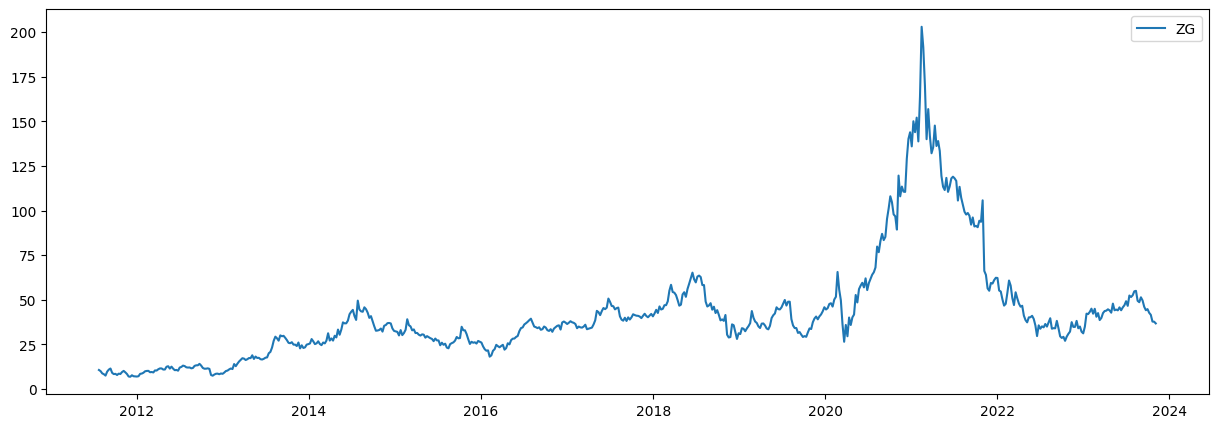

377 out of 431 imploded


377

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
from datetime import datetime
from sklearn.linear_model import LinearRegression
from scipy.stats import norm
from datetime import timedelta
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import os
import csv

imploded_stocks = pd.read_csv('filtered_tickers.csv')
imploded_stocks = imploded_stocks['Ticker'].tolist()

sp500_stocks = pd.read_csv('constituents.csv', usecols=['Symbol'])
sp500_stocks = sp500_stocks['Symbol'].tolist()

russell_stocks = pd.read_csv('russell_2000.csv', usecols = ['Ticker'])
russell_stocks = russell_stocks['Ticker'].tolist()

start_date = '2009-01-01'
end_date = datetime.now().strftime('%Y-%m-%d')

def get_stock_price_weekly(ticker):
    # Suppress the progress message from yfinance
    temp_df = yf.download(ticker, start=start_date, end=end_date, progress=False)

    if temp_df.empty:
        print("No data available for the specified date range.")
        return None
    weekly_data = temp_df['Adj Close'].resample('W').last()
    return weekly_data

def check_implosion(idx, firm_price, imp_thresh):
    i = idx
    start_price=firm_price.iloc[idx]
    i+=1
    period=0
    while i < len(firm_price):
        current_date = firm_price.index[i]
        current_price = firm_price.iloc[i]
        if (current_price-start_price)/start_price > -imp_thresh/2:
            return period
        period+=1
        i+=1
    return period

def get_crash_dates(firm_price, price_drop_thresh=-0.6, period_thresh=52):
    crash_dates = []
    imp_dates = []
    i = 52
    while i < len(firm_price):
        current_date = firm_price.index[i]
        current_price = firm_price.iloc[i]
        prev_year_data = firm_price.iloc[i-52:i]
        if len(prev_year_data) != 0:
            mean_price = prev_year_data.mean()
            if (current_price - mean_price)/mean_price < price_drop_thresh:
                imp_dates.append(current_date)
        i+=1
    return imp_dates

def get_implosion_dates(firm_price, price_drop_thresh=-0.6, period_thresh=52):
    crash_dates = []
    imp_dates = []
    i = 52
    while i < len(firm_price):
        current_date = firm_price.index[i]
        current_price = firm_price.iloc[i]
        prev_year_data = firm_price.iloc[i-52:i]
        if len(prev_year_data) != 0:
            mean_price = prev_year_data.mean()
            if (current_price - mean_price)/mean_price < price_drop_thresh:
                imp_period = check_implosion(i, firm_price,  price_drop_thresh)
                if imp_period > period_thresh:
                    imp_dates.append((current_date, firm_price.index[i+imp_period]))
                i+=imp_period
        i+=1
    return imp_dates

def plot_implosions(stock_series, imp_dates, ticker):
    plt.figure(figsize=(15, 5))
    plt.plot(stock_series.index, stock_series, label=ticker)
    for i in imp_dates:
        plt.axvspan(i[0], i[1], alpha=0.5, color='blue')
    plt.legend()
    plt.show()

def run_imps(stocks_list):
    num_imp = 0
    j = 0
    for t in stocks_list:
        stock_series = get_stock_price_weekly(t)
        if stock_series is not None:
            imp_dates = get_implosion_dates(stock_series)
            # if j % 10 == 0:
            #     plot_implosions(stock_series, imp_dates, t)    
            j+=1
            if len(imp_dates) >= 1:
                num_imp+=1
            if len(imp_dates) ==0:
                plot_implosions(stock_series, imp_dates, t)
    print(f"{num_imp} out of {j} imploded")
    return num_imp

def plot_crashes(ticker):
    stock_series = get_stock_price_weekly(ticker)
    crash_dates = get_crash_dates(stock_series)
    plt.figure(figsize=(15, 5))
    plt.plot(stock_series.index, stock_series, label=ticker)
    for c in crash_dates:
        plt.axvspan(c,c, alpha=0.5, color='blue')
    plt.legend()
    plt.show()



run_imps(imploded_stocks)
#plot_crashes('SEAC')
#APPN,CPS, FOSL, GRPN,PRLB, SEAC
#APPN has not imploded
#CPS has not imploded
#imploded: 377/433, sp500:  russell: 243/1754 imploded

In [32]:
import csv

def save_weekly_prices():
    filtered_tickers = []  # A list to store the ticker names

    for ticker in russell_stocks:
        t_df = get_stock_price_weekly(ticker)
        if t_df is not None:
            max_price = max(t_df)  # Replace 'price' with the actual column name
            if max_price >= 100:
                filtered_tickers.append(ticker)

    csv_file_name = 'filtered_russell_tickers.csv'

    # Open the CSV file in write mode
    with open(csv_file_name, mode='w', newline='') as file:
        writer = csv.writer(file)  # Create a CSV writer object

        # Write the ticker names to the CSV file
        writer.writerow(['Ticker'])  # Write a header row
        for ticker in filtered_tickers:
            writer.writerow([ticker])

save_weekly_prices()



1 Failed download:
['AJRD']: Exception('%ticker%: No timezone found, symbol may be delisted')


No data available for the specified date range.



1 Failed download:
['AMRS']: Exception('%ticker%: No timezone found, symbol may be delisted')


No data available for the specified date range.



1 Failed download:
['APPH']: Exception('%ticker%: No timezone found, symbol may be delisted')


No data available for the specified date range.



1 Failed download:
['ARNC']: Exception('%ticker%: No timezone found, symbol may be delisted')


No data available for the specified date range.



1 Failed download:
['CTIC']: Exception('%ticker%: No timezone found, symbol may be delisted')


No data available for the specified date range.



1 Failed download:
['CVT']: Exception('%ticker%: No timezone found, symbol may be delisted')


No data available for the specified date range.



1 Failed download:
['DICE']: Exception('%ticker%: No timezone found, symbol may be delisted')


No data available for the specified date range.



1 Failed download:
['DSEY']: Exception('%ticker%: No timezone found, symbol may be delisted')


No data available for the specified date range.



1 Failed download:
['ENOB']: Exception('%ticker%: No timezone found, symbol may be delisted')


No data available for the specified date range.



1 Failed download:
['FOCS']: Exception('%ticker%: No timezone found, symbol may be delisted')


No data available for the specified date range.



1 Failed download:
['FORG']: Exception('%ticker%: No timezone found, symbol may be delisted')


No data available for the specified date range.



1 Failed download:
['FRG']: Exception('%ticker%: No timezone found, symbol may be delisted')


No data available for the specified date range.



1 Failed download:
['GRNA']: Exception('%ticker%: No timezone found, symbol may be delisted')


No data available for the specified date range.



1 Failed download:
['HMPT']: Exception('%ticker%: No timezone found, symbol may be delisted')


No data available for the specified date range.



1 Failed download:
['INDT']: Exception('%ticker%: No timezone found, symbol may be delisted')


No data available for the specified date range.



1 Failed download:
['ISEE']: Exception('%ticker%: No timezone found, symbol may be delisted')


No data available for the specified date range.



1 Failed download:
['KDNY']: Exception('%ticker%: No timezone found, symbol may be delisted')


No data available for the specified date range.



1 Failed download:
['NUVA']: Exception('%ticker%: No timezone found, symbol may be delisted')


No data available for the specified date range.



1 Failed download:
['PDLI']: Exception('%ticker%: No timezone found, symbol may be delisted')


No data available for the specified date range.



1 Failed download:
['PRDS']: Exception('%ticker%: No timezone found, symbol may be delisted')


No data available for the specified date range.



1 Failed download:
['PTRA']: Exception('%ticker%: No timezone found, symbol may be delisted')


No data available for the specified date range.



1 Failed download:
['QUOT']: Exception('%ticker%: No timezone found, symbol may be delisted')


No data available for the specified date range.



1 Failed download:
['RIDE']: Exception('%ticker%: No timezone found, symbol may be delisted')


No data available for the specified date range.



1 Failed download:
['ROCC']: Exception('%ticker%: No timezone found, symbol may be delisted')


No data available for the specified date range.



1 Failed download:
['RXDX']: Exception('%ticker%: No timezone found, symbol may be delisted')


No data available for the specified date range.



1 Failed download:
['TFM']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2009-01-01 -> 2023-11-05)')


No data available for the specified date range.



1 Failed download:
['TTCF']: Exception('%ticker%: No timezone found, symbol may be delisted')


No data available for the specified date range.



1 Failed download:
['UBA']: Exception('%ticker%: No timezone found, symbol may be delisted')


No data available for the specified date range.



1 Failed download:
['VRAY']: Exception('%ticker%: No timezone found, symbol may be delisted')


No data available for the specified date range.
